## Data Collection

In [1]:
import os

In [2]:
from sklearn.datasets import load_files

In [3]:
from skimage import io
from skimage.transform import resize
from skimage.feature import hog

In [4]:
import matplotlib.pyplot as plt

In [5]:
import random

In [6]:
def loadImages(path, limit=0, newSize=[], grey=False):
    imgPaths = []
    for imgPath in os.listdir(path):
        imgPaths.append(imgPath)
    if limit>0:
        random.shuffle(imgPaths)
        imgPaths = imgPaths[:limit]
    if grey:
        imgs = [io.imread(path+'/'+img, as_gray=True) for img in imgPaths]
    else:
        imgs = [io.imread(path+'/'+img)/255 for img in imgPaths] #grey imshow
    if newSize:
        imgs = [resize(img, newSize) for img in imgs]
    return imgs

In [7]:
negativeData = loadImages("Negative Images", newSize=[128,128]) #Same size as positive images

In [8]:
len(negativeData)

3030

In [9]:
negativeData[0]

array([[0.53584436, 0.54724017, 0.81900192, ..., 0.25156204, 0.28540371,
        0.33505688],
       [0.5480727 , 0.54958522, 0.79067971, ..., 0.27693003, 0.30344286,
        0.32327681],
       [0.41417738, 0.51109216, 0.57154217, ..., 0.2359545 , 0.26075544,
        0.24389031],
       ...,
       [0.5765858 , 0.58342175, 0.580009  , ..., 0.37302246, 0.34518521,
        0.35297904],
       [0.56853809, 0.57188977, 0.57464074, ..., 0.41313492, 0.39615051,
        0.39177674],
       [0.56562596, 0.57504121, 0.57893574, ..., 0.45673561, 0.45947218,
        0.41308217]])

(-0.5, 127.5, 127.5, -0.5)

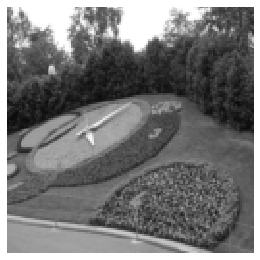

In [10]:
io.imshow(negativeData[0])
plt.axis('off')

In [11]:
positiveData = loadImages("Positive Images", len(negativeData), grey=True)

(-0.5, 127.5, 127.5, -0.5)

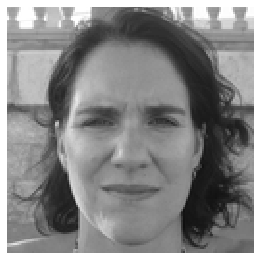

In [152]:
io.imshow(positiveData[0])
plt.axis('off')

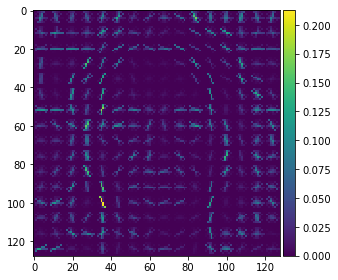

In [157]:
io.imshow(hog(positiveData[0], visualize=True)[1])

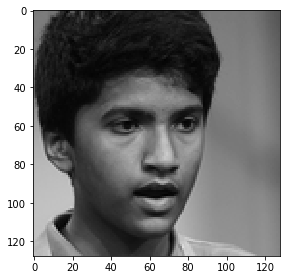

In [12]:
io.imshow(positiveData[0])

In [13]:
X = positiveData + negativeData

In [15]:
import numpy as np

In [16]:
y = np.zeros(len(X))
y[:len(positiveData)] = 1

In [17]:
X = np.asarray([hog(img) for img in X]) # Feature Extraction

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

## Feature Analysis

In [20]:
X[0]

array([0.03883749, 0.03290249, 0.11375909, ..., 0.00927726, 0.03446161,
       0.31054486])

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [23]:
X_pca.shape

(6060, 2)

In [24]:
X.shape

(6060, 15876)

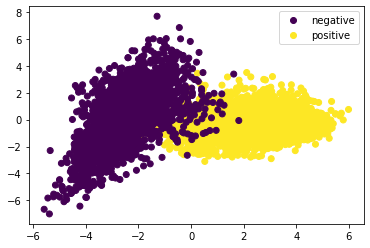

In [25]:
dataVis = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.legend(handles=dataVis.legend_elements()[0], labels=["negative","positive"])

In [26]:
pca.explained_variance_ratio_

array([0.07120597, 0.02694902])

#### Hypothesis: Most of the face data is recognised as being similar, due to the lack of variation in the y-axis

## Data learning

In [27]:
X.shape

(6060, 15876)

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [30]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
model.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))

## Evaluation

In [31]:
from sklearn.metrics import recall_score

In [32]:
y_pred = model.predict(X_test)

In [33]:
recall_score(y_test, y_pred)

0.9950310559006211

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
confMatrix = confusion_matrix(y_test,y_pred)

In [36]:
confMatrix

array([[710,   0],
       [  4, 801]], dtype=int64)

In [50]:
from skimage.color import rgb2gray

In [44]:
test_image = io.imread("NASA_Astronaut_Group_18.jpg")

In [56]:
test_image_grey = rgb2gray(test_image/255)

In [49]:
test_image.shape

(768, 1018, 3)

In [76]:
test_image_grey.shape

(768, 1018)

(-0.5, 1017.5, 767.5, -0.5)

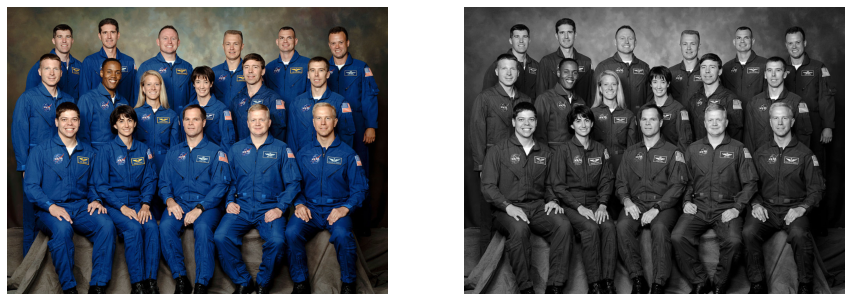

In [59]:
fig, axes = plt.subplots(1,2, figsize=(15,20))
axes[0].imshow(test_image)
axes[1].imshow(test_image_grey, cmap="gray")
axes[0].axis("off")
axes[1].axis("off")

In [60]:
from sklearn.feature_extraction.image import extract_patches_2d

In [66]:
from skimage.util.shape import view_as_windows

In [109]:
def patchesHog(img, window_size):
    patches = view_as_windows(test_image_grey, window_size)
    patches_hog = [hog(img) for img in patches]
    io.imshow(patches[15][90])
    plt.axis("off")
    return patches_hog

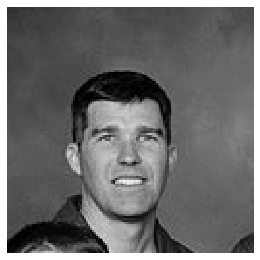

In [113]:
test_image_Hog = patchesHog(test_image_grey, (128,128))

In [118]:
test_image_Hog = np.asarray(test_image_Hog)

In [124]:
X_train.shape

(4545, 15876)

In [159]:
test_image_Hog[:15876].shape

(641, 123606)

In [160]:
y_detect_pred = model.predict(test_image_Hog) #error if features not equal

ValueError: Number of features of the model must match the input. Model n_features is 15876 and input n_features is 123606 

In [148]:
np.reshape(test_image_Hog, (-1, 1, test_image_Hog.shape[1])).shape

(641, 1, 123606)

In [111]:
import pickle

In [112]:
with open("FER1.pickle", "wb") as handle:
    pickle.dump(model, handle)